# Hard EM - Convolutional VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

We test this notebook considering an adam optimiser for both the VAE and the E and M steps of DLM hard EM.

# Fitting a distribution $q_n$ given $\boldsymbol\theta$

In this section, we find a variational distribution $q_n$ for $\boldsymbol\theta_\text{vae}$ and $\boldsymbol\theta_\text{hard-em}$. We consider a dataset ${\bf X}_\text{test}$ and train an unamortised variational distribution of the form

$$
    q_n(z_n) = \mathcal{N}(z_n \vert \mu_n, \sigma_n)
$$

In [2]:
import jax
import json
import glob
import tomli
import pickle
import flax.linen as nn
import numpy as np
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = "retina"

In [8]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [119]:
def build_iwmll_df(output):
    dict_mll_epochs = output["test"]
    df_all = []
    for key in dict_mll_epochs:
        df_mll = pd.DataFrame.from_dict(dict_mll_epochs[key])
        df_mll.columns = ["hard-em", "vae"]
        df_mll = pd.DataFrame.from_dict(dict_mll_epochs[key])
        df_mll.columns = [f"hard-em", "vae"]
        df_mll = df_mll.melt(value_name="mll")
        df_mll["episode"] = int(key.lstrip("e"))
        df_all.append(df_mll)
    df_all = pd.concat(df_all, axis=0)
    return df_all

## Load base configuration

In [5]:
path_config = "../experiments/configs/fmnistv01.toml"
with open(path_config, "rb") as f:
    config = tomli.load(f)

print(json.dumps(config, indent=2))

{
  "warmup": {
    "num_obs": 10000,
    "num_epochs": 1000,
    "batch_size": 200,
    "dim_latent": 50,
    "eval_epochs": [
      2,
      10,
      100,
      250,
      500,
      1000
    ],
    "learning_rate": 0.001,
    "vae": {
      "num_is_samples": 10
    },
    "hard_em": {
      "num_its_latent": 20,
      "num_its_params": 5
    }
  },
  "test": {
    "num_obs": 1000,
    "num_epochs": 1000,
    "learning_rate": 0.0001,
    "num_is_samples": 10
  }
}


In [15]:
# Based on:
# https://github.com/probml/probml-utils/blob/main/probml_utils/conv_vae_flax_utils.py
class Encoder(nn.Module):
    latent_dim: int
    hidden_channels: Sequence[int]

    @nn.compact
    def __call__(self, X, training):
        for channel in self.hidden_channels:
            X = nn.Conv(channel, (3, 3), strides=2, padding=1)(X)
            X = nn.BatchNorm(use_running_average=not training)(X)
            X = jax.nn.relu(X)

        X = X.reshape((-1, np.prod(X.shape[-3:])))
        mu = nn.Dense(self.latent_dim)(X)
        logvar = nn.Dense(self.latent_dim)(X)

        return mu, logvar


class Decoder(nn.Module):
    output_dim: Tuple[int, int, int]
    hidden_channels: Sequence[int]

    @nn.compact
    def __call__(self, X, training):
        H, W, C = self.output_dim

        # TODO: relax this restriction
        factor = 2 ** len(self.hidden_channels)
        assert (
            H % factor == W % factor == 0
        ), f"output_dim must be a multiple of {factor}"
        H, W = H // factor, W // factor

        X = nn.Dense(H * W * self.hidden_channels[-1])(X)
        X = jax.nn.relu(X)
        X = X.reshape((-1, H, W, self.hidden_channels[-1]))

        for hidden_channel in reversed(self.hidden_channels[:-1]):
            X = nn.ConvTranspose(
                hidden_channel, (3, 3), strides=(2, 2), padding=((1, 2), (1, 2))
            )(X)
            X = nn.BatchNorm(use_running_average=not training)(X)
            X = jax.nn.relu(X)

        X = nn.ConvTranspose(C, (3, 3), strides=(2, 2), padding=((1, 2), (1, 2)))(X)
        X = jax.nn.sigmoid(X)

        return X

In [16]:
dict_models = {
    "class_decoder": Decoder,
    "class_encoder": Encoder,   
    "class_encoder_test": hlax.models.GaussEncoder,
}

# Learning rates

## Iteration - 01

In [ ]:
output = base_vae_hardem.main(config, dict_models)

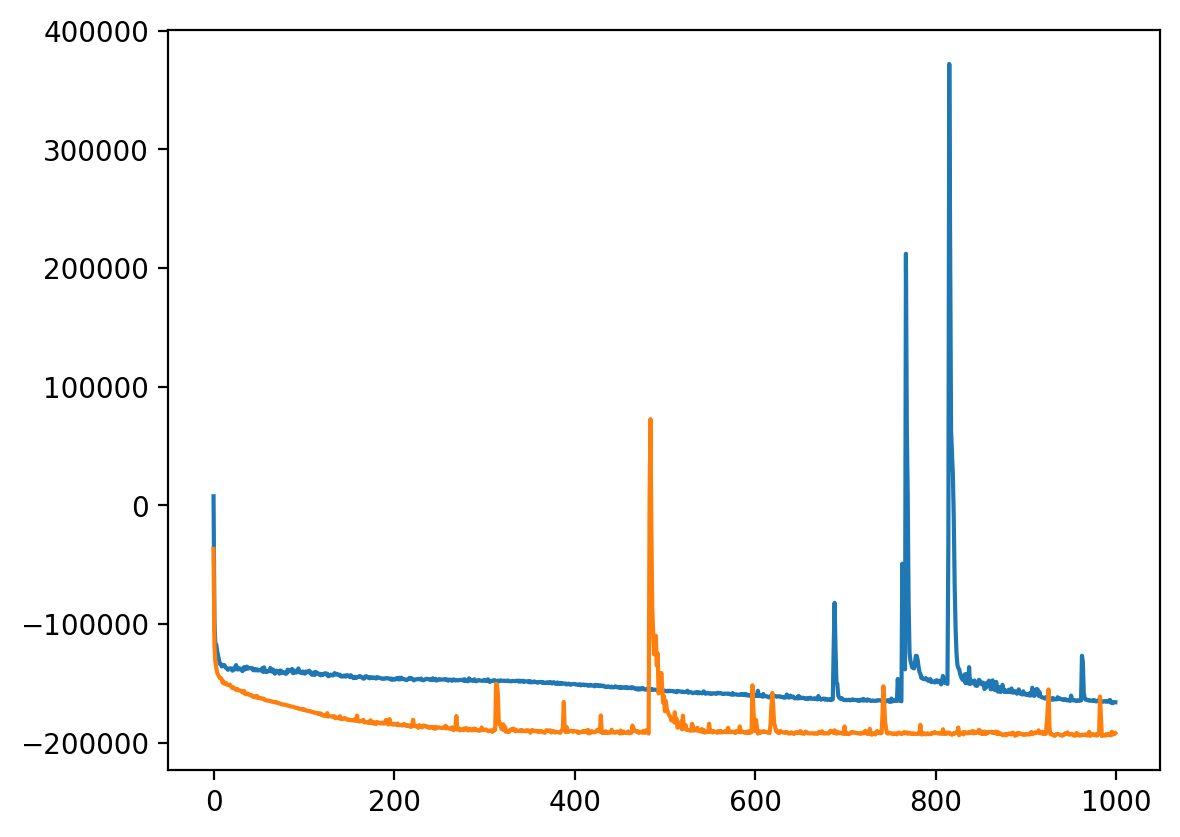

In [26]:
plt.plot(output["warmup"]["vae"]["hist_loss"])
plt.plot(output["warmup"]["hardem"]["hist_loss"])

### IWMLL

In [88]:
df_all = build_iwmll_df(output)

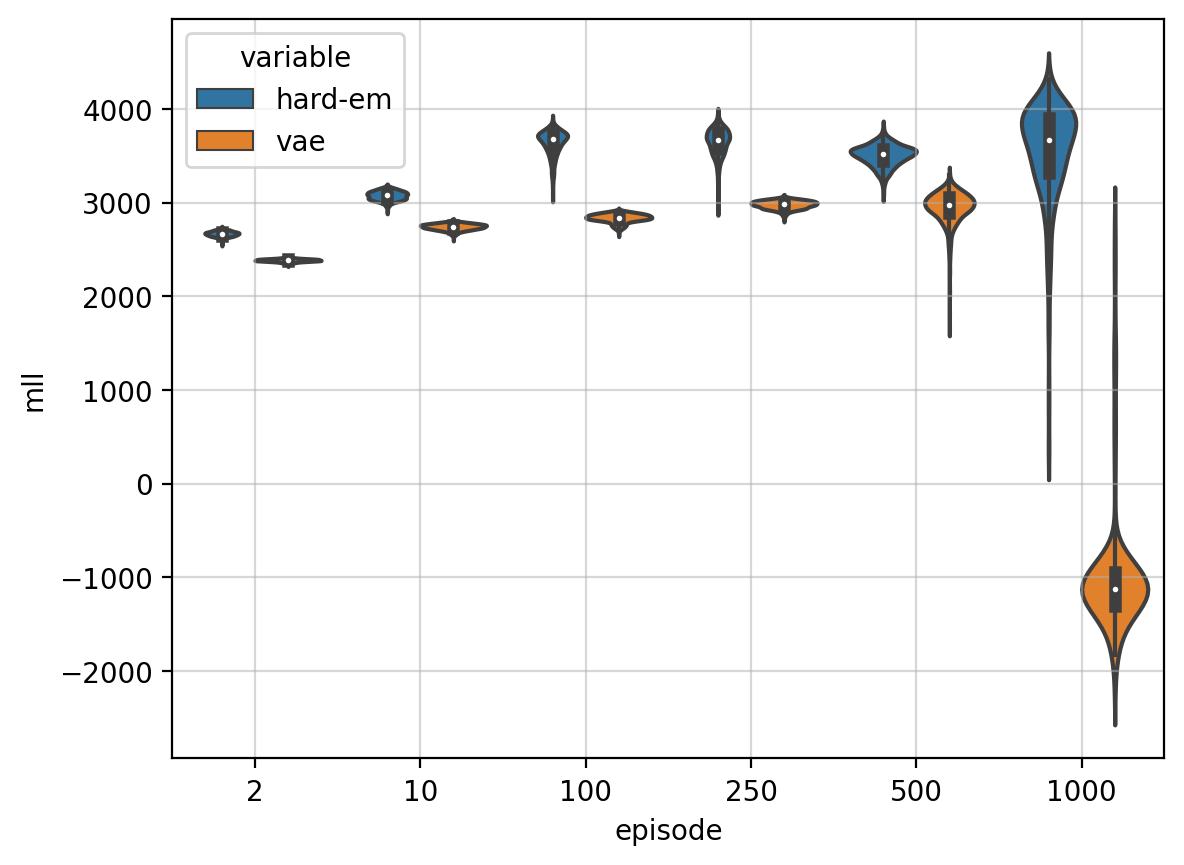

In [ ]:
sns.violinplot(x="episode", y="mll", hue="variable", data=df_all)
plt.grid(alpha=0.5)